In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

### Data Processing

In [3]:
clinical = pd.read_pickle("C:\\SMU_v2\\clinical_output.pkl").reset_index().drop(columns="index")
to_drop = clinical[clinical['dx_date']=="NA"].index
clinical = drop_by_index(clinical,to_drop)

clinical.drop(columns=['NRIC','dob',\
                       'Count_as_DFS','Count_as_OS','Count_as_CSS'],inplace = True)

# drop all rows where dates are null
    # wave 1 details
clinical.dropna(axis=0, \
                subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date',\
                        'size_precise', 'nodespos'],\
                inplace=True)
# wave 2 details


# convert all datetime in dataframe into dateime format for processing
clinical["Date_for_DFS"] = pd.to_datetime(clinical["Date_for_DFS"])
clinical["Date_for_OS"] = pd.to_datetime(clinical["Date_for_OS"])
clinical["Date_for_CSS"] = pd.to_datetime(clinical["Date_for_CSS"])
clinical["dx_date"] = pd.to_datetime(clinical["dx_date"])
clinical['last_seen']= pd.to_datetime(clinical["dx_date"])


# calculate in days
clinical["DFS_days"] = (clinical["Date_for_DFS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')
clinical["OS_days"] = (clinical["Date_for_OS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')
clinical["CSS_days"] = (clinical["Date_for_CSS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')

# alive or dead
clinical['status'] = np.where(clinical['death_age'].isnull(), False, True)

In [4]:
clinical.describe()
# clinical.to_csv("C:\\Users\\LINGXING\\Desktop\\clinical.csv",index = False)

,size_precise,nodespos,death_age,DFS_days,OS_days,CSS_days
count,16127.000000,16127.000000,2785.000000,16127.000000,16127.000000,16127.000000
mean,2.543278,1.985352,62.619031,2443.832827,2760.432753,2750.367086
std,2.277692,4.871094,13.333973,1859.186368,1993.165784,1991.466345
min,0.000000,0.000000,26.000000,-2627.000000,-1597.000000,-2627.000000
25%,1.200000,0.000000,53.000000,890.500000,1144.000000,1136.000000
50%,2.000000,0.000000,62.000000,2047.000000,2357.000000,2343.000000
75%,3.200000,2.000000,72.000000,3685.500000,4034.500000,4024.500000
max,99.900002,73.000000,100.000000,12650.000000,15596.000000,15596.000000


### Data filtering

Data of our interest are 5 and 10 years, patient that are new (does not have sufficient records will disturb and mess up our accuracy level

In [5]:
'''
df_dict[] : 5 years | 10 years data
df_dict[][] : years, survival type
'''
df_dict = {}
  
#years that we are interested in
for i in list([1,2,5,10]):
    tmp = {}
    for x in list(["DFS", "CSS", "OS"]):
        clinical['{}_{}_years'.format(x, i)] = np.where(
                                                         np.logical_or(clinical['death_age'] > 0,\
                                                         clinical['{}_days'.format(x)]/(365.25*i) >= i),\
                                                True,False)
        tmp[x] = clinical[clinical['{}_{}_years'.format(x, i)] == True]
    df_dict['{}_years'.format(i)] = tmp

### Display shape of data after filtering

In [6]:
for i in df_dict:
    for s_type in df_dict[i]:
        print("Year: {}, survival type: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape))

Year: 1_years, survival type: DFS, size: (14946, 218)
Year: 1_years, survival type: CSS, size: (15118, 219)
Year: 1_years, survival type: OS, size: (15118, 220)
Year: 2_years, survival type: DFS, size: (11792, 221)
Year: 2_years, survival type: CSS, size: (12276, 222)
Year: 2_years, survival type: OS, size: (12276, 223)
Year: 5_years, survival type: DFS, size: (2816, 224)
Year: 5_years, survival type: CSS, size: (2867, 225)
Year: 5_years, survival type: OS, size: (2867, 226)
Year: 10_years, survival type: DFS, size: (2785, 227)
Year: 10_years, survival type: CSS, size: (2785, 228)
Year: 10_years, survival type: OS, size: (2785, 229)


In [35]:
#process the confidence interval 
display(clinical.head())
display(clinical.loc[:,["status","OS_days"]].head())

data = clinical["OS_days"]

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

for 

# mean, LCI, UCI = mean_confidence_interval(data)
# print(mean, LCI, UCI)

,Has Bills?,Side,Hospital,KKH,NCCS,SGH,Gender,Race,Marital_Status,Height,Weight,Smoker,Alcohol,ECOG,comorbidity,sync_ca_date,sync_ca_desc,hx_other_ca_date,hx_other_ca_desc,parity,Oral_Contraceptive,famhx,Breast_Feed,Merche_At,Menopause_Status,Age.Menopause,First_Child_At,Hor_replacement,Presentation,Doctor_In_Charge,previous_dx_date,previous_stagingtype,Previous_T,Previous_N,Previous_M,Previous_stage,Rx_date,firstsee,dx_date,srgdate,Breast_surgery,operation_summ,Recon,Reconstruction,Surgeon,Genomic_Test,Recurrence_Score,Site,Histology,HistCode_WWXX,c_tstage,cNstage,cMstage,c_Staging,tstage,nstage,Mstage,p_Staging,Ajcc8_phyllodes_tstage,diff,TNM_Stage,ProgStage_AJCC8,AJCC8_Staging,er_intensity,er_percentage,ER,pr_intensity,pr_percentage,PR,cerbB2_intensity,cerbB2_percentage,cerbB2,FISH,fish_ratio,Her2,size_precise,Size,closet_radial_margin,Margins_mm,margins,margins_calc,Multi_focality,Multi_centricity,Extensive_Intraductal_Component,Comedo_Necrosis,Pleomorphism,VNPI,invasion,slnb,slnb_positive,no_sentinel_node,nodespos,nodesrem,False_Negative_SLNB,Non_SLN,ac,AClevel,hrt,TMX,X.1st_Tamoxifen,Last_Tamoxifen,hrt2,hrt2_desc,hrt2_start,hrt2_end,Targeted,X.1st_Herceptin,Last_Herceptin,Herceptincycles,Herceptindose_mg,Neo_Adjuvant,neo_adj_chemo_start,neo_adj_chemo_end,neo_adj_chemo_regimen_desc,neo_adj_chemo_regimen,neo_adj_chemo_cycle,neo_adj_chemo_dose,chemo,Chemo_Intent_not_neoadj,chemo_start,chemo_end,other_chemo_regimen,chemo_regimen,chemo_cycle,RT,RT_intent,technique,RT_Technique,rtstart,rtend,field,fractions,dose,scdose,midplane,intmamm,cwdose_cGy,boostdose_cGy,scdose_cGy,axdose_cGy,intmamdose_cGy,TreatmentCycleType,treatment_remarks,firstfail,First_Fail,First_Fail_Date,Second_Fail,Second_Fail_Date,Third_Fail,Third_Fail_Date,Mets.Dx,New_mets,Site_mets,remarks,New_primary,Local_Desc,Local_nontrue_desc,Nodal_recur,contra_remarks,status,lastseen,deathcode,cause_of_death,MHA_COD,Date_for_DDFS,Date_for_IBTR,Date_for_True_Local_Recurrence,Date_for_Other_Local_Recurrence,Date_for_Nodal_Recurrence,Date_for_Contra_Rec,event_dt,Date_for_DFS,Date_for_OS,Date_for_CSS,Count_as_EVENTS,Count_as_DDFS,Count_as_IBTR,Count_as_True_Local_Recurrence,Count_as_Other_Local_Recurrence,Count_as_Nodal_Recurrence,Count_as_Contra_Rec,chestsiz_recode,Chestsiz_dichotomise,TNM_collapse,TNM_I_vs_II,Time_OS,Time_CSS,Time_IBTR,Time_IBTRTrue,Time_DFS,Time_DDFS,Time_ContraRec,Age_@_Dx,Histo_subtype,Histo_subtype_collapse,Histo_subtype_collapser,subtype_stg2013,subtype_stg2013_lumb,Triple_Neg,resident,mastect,surgfirst,Date_for_IDFS,Date_for_DSS,Date_for_RFS,Count_as_IDFS,Count_as_DSS,Count_as_RFS,Time_IDFS,Time_DSS,Time_RFS,END_OF_ENTRY,death_age,last_seen,DFS_days,OS_days,CSS_days,DFS_1_years,CSS_1_years,OS_1_years,DFS_2_years,CSS_2_years,OS_2_years,DFS_5_years,CSS_5_years,OS_5_years,DFS_10_years,CSS_10_years,OS_10_years
0,Y,left,SGH/NCC,NaN,NCCS,SGH,female,chinese,Married (including common law),1.52,62.2,Yes,Former,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,no,No,14,Post,37,NaN,NaN,Clinical,2,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-23 00:00:00,2007-08-15 00:00:00,2007-06-12,2007-07-23 00:00:00,Breast Conservation Therapy,l breast lump wide excision,No,NaN,11,NaN,NaN,lower outer,intra ductal (DCIS),NaN,tx,nx,mx,unknown,tis,n0,m0,dcis/lcis non-invasive,NaN,grade 2,dcis/lcis non-invasive,stage 0,Stage 0,3+,NaN,positive,3+,NaN,positive,Negative,NaN,negative,Not Done,NaN,negative,4.0,3.01 to 4 cm,NaN,4,0 to 5 mm,NaN,No,No,pure DCIS,Non Comedo,NaN,non-high gd w/out comedo,no,no,0,0,0.0,0,NaN,NaN,no,NaN,Tamoxifen only,TMX,2007-10-25 00:00:00,2012-11-02 00:00:00,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NA,NaN,yes,NaN,OPP TANGENTIAL,Opp Tangential,2007-09-27 00:00:00,2007-10-24 00:00:00,breast only,15,4005 + boost 1110,no treatment,no treatment,no treatment,4005,1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2018-05-05 00:00:00,NaN,n,SPONTANEOUS LEFT BASAL GANGLIA AND THALAMIC IN...,2018-05-05 00:00:00,20

,status,OS_days
0,True,3980.0
1,False,265.0
2,False,1961.0
3,False,2636.0
4,False,195.0


2760.4327525268186 2729.6684326003524 2791.197072453285


### Kaplan Meier Analysis

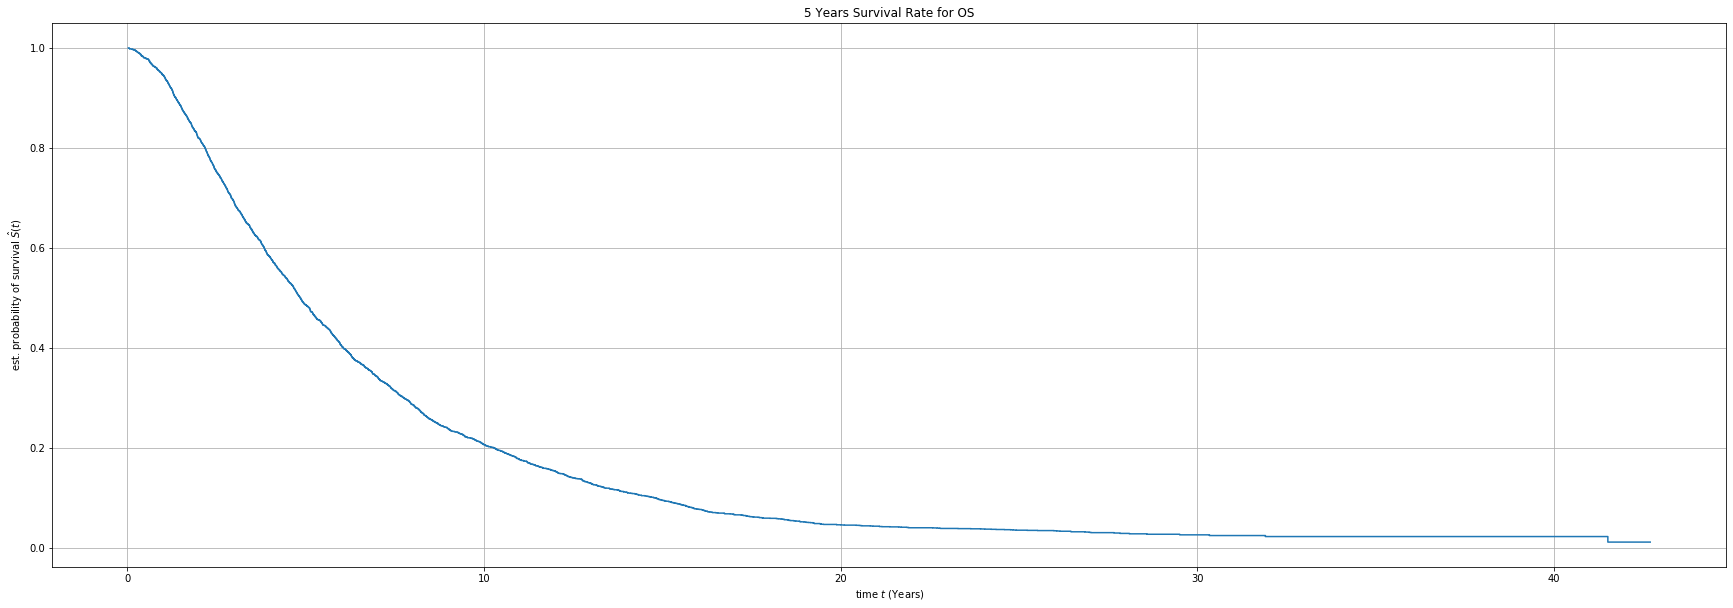

In [17]:
from sksurv.nonparametric import kaplan_meier_estimator

YEAR = 5
STYPE = "OS"

time, survival_prob = kaplan_meier_estimator(df_dict['{}_years'.format(YEAR)][STYPE]['status'], 
                                             df_dict['{}_years'.format(YEAR)][STYPE]['OS_days'])
time = time/365.25
# print(max(time),min(time))
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (Years)")
plt.title("{} Years Survival Rate for {}".format(YEAR,STYPE))
plt.grid(True)

Time Treatment:  [-2627. -1611.  -105. ... 11424. 11655. 12650.]
Survival prob:  [0.99964489 0.99928977 0.99893466 ... 0.01002213 0.00501106 0.00501106]
Time Treatment:  [1.1000e+01 1.4000e+01 1.5000e+01 ... 1.4244e+04 1.5162e+04 1.5596e+04]
Survival prob:  [0.9996512  0.99930241 0.99895361 ... 0.02215864 0.01107932 0.01107932]
Time Treatment:  [-2.6270e+03 -6.3000e+01  1.1000e+01 ...  1.4244e+04  1.5162e+04
  1.5596e+04]
Survival prob:  [0.9996512  0.99930241 0.99895361 ... 0.02231385 0.01115692 0.01115692]


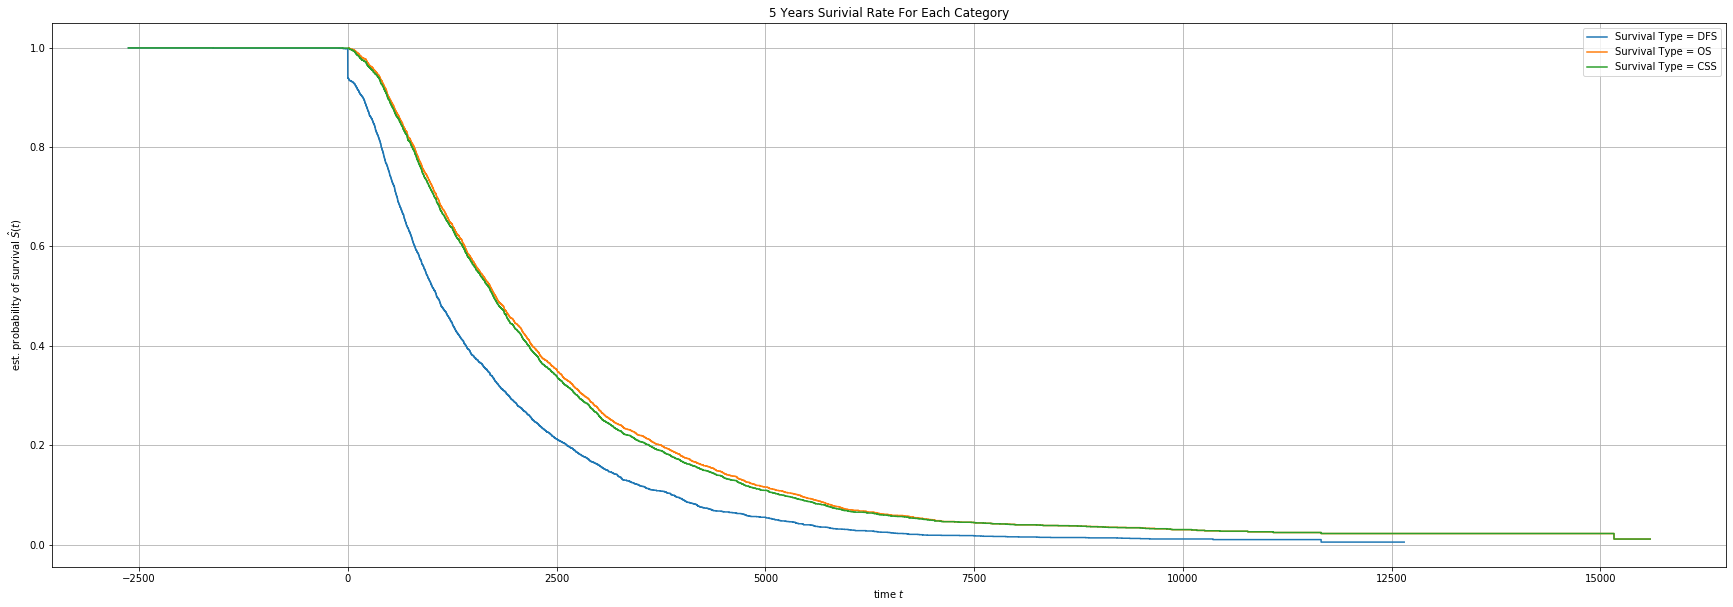

In [36]:
Years = 5

for survival in ("DFS", "OS", 'CSS'):
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_dict['{}_years'.format(YEAR)][survival]['status'],
        df_dict['{}_years'.format(YEAR)][survival]['{}_days'.format(survival)])
    
    print("Time Treatment: ", time_treatment)
    print("Survival prob: ", survival_prob_treatment)
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Survival Type = {}".format(survival))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("{} Years Surivial Rate For Each Category".format(YEAR))
plt.grid(True)
plt.legend(loc="best")

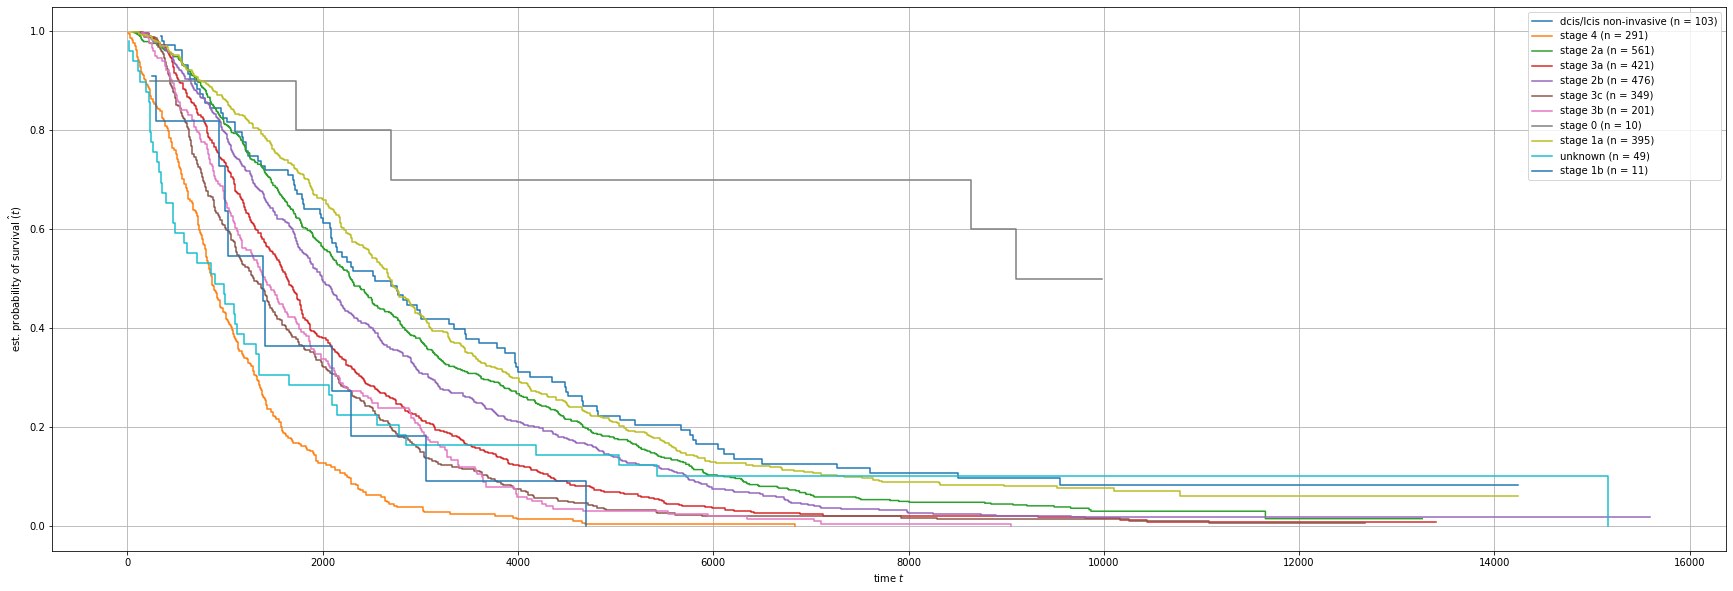

In [9]:
plt.rcParams["figure.figsize"] = (30,10)
for value in df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"].unique():
    mask = df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_dict['{}_years'.format(YEAR)][STYPE]['status'][mask],
                                                           df_dict['{}_years'.format(YEAR)][STYPE]['{}_days'.format(STYPE)][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label= '{} (n = {})'.format(value, mask.sum()))

plt.ylabel("est. probability of survival $\hat(t)$")
plt.xlabel("time $t$")
plt.grid(True)
plt.legend(loc="best")